<a href="https://colab.research.google.com/github/Ayfred/MissionR-D/blob/main/SAFE_application1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Data/onlyEnComments.csv"
df_content = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Chargement des données CSV

In [125]:
import csv

# open the CSV file using the csv module
with open(path, newline='',  encoding='utf-8') as csvfile:
    # create a csv reader object
    reader = csv.reader(csvfile)
    # create an empty list to store the strings
    string_list = []
    # loop through each row in the CSV file
    for row in reader:
        # add the string to the list
        #if detect(row[0]) == 'fr':
        string_list.append(row[0])

In [126]:
string_list = string_list[:1000]

In [127]:
#print((string_list[1]))

Pre-traitement du texte

In [128]:
import re
import spacy

!python -m spacy download en_core_web_sm

2023-04-11 09:42:38.170334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [129]:
#Etapes du texte Preprocessing
nlp = spacy.load("en_core_web_sm")
listStopWords = [str(x) for x in nlp.Defaults.stop_words]

In [130]:
def united(text):
    doc =  text.split(" ");
    # Itérer à travers chaque token dans le document
    for token in doc:
        if token in ["because", "since", "as", ]:
            doc = doc[:doc.index(token)]
            break
        #Remove explanations
        # Si le token est "parce que", "car" ou "puisque", supprimer tous les tokens suivants dans la phrase
        
    
    # Supprimer tout ce qui est entre parenthèses
    sentence = ' '.join(doc)
    sentence = re.sub(r'\([^()]*\)', '', sentence)

    #print(f"remove explanations : {sentence}")

    sentence = re.sub('http[s]?://\S+', '', sentence)

    #print(f"remove links: {sentence}")


    # Regular expressions for phone numbers and email addresses
    quotes = r'\"[^\"]+\"'
    phone_regex = r"(?<!\d)(?:\d[ -/\\_\d]*){10}(?!\d)"
    email_regex = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"  # matches john.doe@example.com

    # Find phone numbers and email addresses in the sentence
    sentence = re.sub(quotes,"", sentence)

    #print(f"remove links2: {sentence}")


    sentence = re.sub(phone_regex,"", sentence)
    sentence = re.sub(email_regex,"", sentence)
    sentence = re.sub(r'[^\w]', ' ', sentence)
    doc = sentence.split(" ")
    for word in doc:
        if word in listStopWords:
            doc.remove(word)
    
    sentence = ' '.join(doc)

    #print(f"remove phone numbers and contacts: {sentence}")

    #Removal of ' and the char that precede it
    sentence = sentence.replace("'", " ")

    #print(f"remove leopaul: {sentence}")

    words = sentence.split(" ")
    newSentence = ""
    for word in words:
        if len(word) > 1:
            newSentence += word + " "
    sentence = newSentence
    
    #print(f"remove quotes : {sentence}")

    doc = nlp(sentence)
    #texte = doc.text
    text = ""
    for token in doc:
        if (token.pos_ == "PRON" or token.pos_ == "DET"):
            continue
        else:
            if not token.text.__contains__("'"):
                text += token.text
                text += " "
    sentence = text

    #print(f"remove pronoum and determinant : {sentence}")


    doc = nlp(sentence)
    result = []
    for token in doc:
        if not (token.ent_type_ == "ORG" or token.ent_type_ == "PERSON" or token.text.istitle()):
            result.append(token.text)
    sentence =  " ".join(result)
    #print(f"remove proper noun : {sentence}")

    return sentence

"""
for string in string_list:
    united_string = united(string)
    string_list_clean.append(united_string)
print(string_list_clean)
#run
#print(united(text))"""
united_string = []
for i in range(len(string_list)):
  united_string += [united(string_list[i])]



In [131]:
united_string

['designed good selection workout options does good job tracking sleep wish option add note journal entry sleep session if was simple regards watch app think should more breathing cycles section',
 'buggy appears be way report bugs stars can contact experience tell to reset watch experience helps requires to set watch up',
 'best frequently don work composition works maybe 30 time then stops watch isn tight arms aren far out maybe',
 'about',
 'synced app used have problems capability frequently experience workouts are synced app restarted sync worked fine couple days doesn AGAIN VERY frustrating distance not close being accurate jnside apartment building when walking halls near parameter building',
 'app slowly losing features long time has been chore but simply tedious example to scan food labels anymore be manually entered doesn care app',
 'good app be improved has downgraded little ways instance scheduling workouts be customizable have daily weekly routine set by user not be days 

Apply SAFE POS pattern

In [132]:
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher1 = Matcher(nlp.vocab)
matcher2 = Matcher(nlp.vocab)
matcher3 = Matcher(nlp.vocab)

"""def deleteTokens(matcher, doc, i, matches):
    # Get the current match and create tuple of entity label, start and end.
    # Append entity to the doc's entity. (Don't overwrite doc.ents!)
    match_id, start, end = matches[i]
    string_id = nlp.vocab.strings[match_id]
    text = ""

    nlp_list = list(doc)
    for i in range(end-start):
        text += nlp_list[start].text + " "
        del nlp_list[start]
    print("\n")
    print(text)
    print("\n")
    print(nlp_list)
    doc = nlp(" ".join([e.text for e in nlp_list]))
    matched_list.append(text)
    matched_id_list.append(string_id)"""


# Add match ID "HelloWorld" with no callback and one pattern
pattern1 = [{"POS": "NOUN"}, {"POS": "NOUN"}]
pattern2 = [{"POS": "VERB"}, {"POS": "NOUN"}]
pattern3 = [{"POS": "ADJ"}, {"POS": "NOUN"}]
pattern4 = [{"POS": "NOUN"}, {"POS": "CCONJ"}, {"POS": "NOUN"}]
pattern5 = [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
pattern6 = [{"POS": "NOUN"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
pattern7 = [{"POS": "VERB"}, {"POS": "PRON"}, {"POS": "NOUN"}]
pattern8 = [{"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
pattern9 = [{"POS": "VERB"}, {"POS": "ADJ"}, {"POS": "NOUN"}]
pattern10 = [{"POS": "ADJ"}, {"POS": "ADJ"}, {"POS": "NOUN"}]
pattern11 = [{"POS": "NOUN"}, {"POS": "ADP"}, {"POS": "NOUN"}]
pattern12 = [{"POS": "VERB"}, {"POS": "DET"}, {"POS": "NOUN"}]
pattern13 = [{"POS": "VERB"}, {"POS": "NOUN"}, {"POS": "ADP"}, {"POS": "NOUN"}]
pattern14 = [{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
pattern15 = [{"POS": "ADJ"}, {"POS": "CONJ"}, {"POS": "ADJ"}]
pattern16 = [{"POS": "VERB"}, {"POS": "ADP"}, {"POS": "ADJ"}, {"POS": "NOUN"}]
pattern17 = [{"POS": "VERB"}, {"POS": "PRON"}, {"POS": "ADJ"}, {"POS": "NOUN"}]
pattern18 = [{"POS": "NOUN"}, {"POS": "CCONJ"}, {"POS": "NOUN"}, {"POS": "NOUN"}]
matcher1.add("18", [pattern18])
matcher1.add("17", [pattern17])
matcher1.add("16", [pattern16])
matcher2.add("15", [pattern15])
matcher1.add("14", [pattern14])
matcher1.add("13", [pattern13])
matcher2.add("12", [pattern12])
matcher2.add("11", [pattern11])
matcher2.add("10", [pattern10])
matcher2.add("9", [pattern9])
matcher2.add("8", [pattern8])
matcher2.add("7", [pattern7])
matcher2.add("6", [pattern6])
matcher2.add("5", [pattern5])
matcher2.add("4", [pattern4])
matcher3.add("3", [pattern3])
matcher3.add("2", [pattern2])
matcher3.add("1", [pattern1])

matched_id_list = []
matched_list = []
#doc = nlp("Song and artist album,  Create your greatest album, ")

for row in range(len(united_string)):
  doc = nlp(united_string[row])
  while(True):
    matches = matcher1(doc)
    for match_id, start, end in matches:
      string_id = nlp.vocab.strings[match_id]
      nlp_list = list(doc)
      print(doc[start:end])
      matched_list.append(doc[start:end])
      matched_id_list.append(string_id)

      for i in range(end-start):
        if(start<len(nlp_list)):
          del nlp_list[start]

      doc = nlp(" ".join([e.text for e in nlp_list]))
    if (not matches):
      break
  while(True):
    matches = matcher1(doc)
    for match_id, start, end in matches:
      string_id = nlp.vocab.strings[match_id]
      nlp_list = list(doc)
      print(doc[start:end])
      matched_list.append(doc[start:end])
      matched_id_list.append(string_id)

      for i in range(end-start):
        if(start<len(nlp_list)):
          del nlp_list[start]

      doc = nlp(" ".join([e.text for e in nlp_list]))
    if (not matches):
      break
  while(True):
    matches = matcher1(doc)
    for match_id, start, end in matches:
      string_id = nlp.vocab.strings[match_id]
      nlp_list = list(doc)
      print(doc[start:end])
      matched_list.append(doc[start:end])
      matched_id_list.append(string_id)

      for i in range(end-start):
        if(start<len(nlp_list)):
          del nlp_list[start]

      doc = nlp(" ".join([e.text for e in nlp_list]))
    if (not matches):
      break


#Remove duplicate and synonyms, noise
print(matched_list)

good selection workout options
wish option add note

good job tracking sleep

more breathing cycles section
accurate jnside apartment building
building
walking halls near parameter
little ways instance scheduling

good meassure steps distance
enter data back sleep
best feature fact review
route feature
disappointing app return map
longer workout notifications steps
past week use galaxy
won load calendar longer
showing on main screen
turn phone for minute
let sign with account
wish edit time sleep
nutritional information item search
total sleep time graph
old phone monitor heart
best app fitness hands
main function app weight
inconsistent records sleep exercise
proper stretching practice idea
decent job tracking activity
reminder automatic sleep detection
automatic activity tracker sleep
able benefit data points
handy feature blood glucose
next update returns recording
non food tracking barcode
coarse exercise mispronounces words
great app health majority
great app tracking basics
graph

In [133]:
for el in matched_list:
  if len(el.text.split(" "))<=1:
    matched_list.remove(el)

In [134]:
#matched_list

In [135]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# Load pre-trained language model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define number of clusters
num_clusters = 63

# Define the list of phrases to cluster
phrases = matched_list

# Encode the phrases using the pre-trained model
phrase_embeddings = model.encode(phrases)

# Cluster the embeddings using K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(phrase_embeddings)

# Assign each phrase to a cluster
clusters = [[] for i in range(num_clusters)]
for i, label in enumerate(kmeans.labels_):
    clusters[label].append(phrases[i])

# Print the clusters
for i in range(num_clusters):
    print("Cluster {}:".format(i+1))
    print(clusters[i])


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1:
[contact first email, online support hour phone]
Cluster 2:
[lost results works fine, want remove from friend, replaced by only step, deteriorated basically just tracking, had replace watch seriously, built end workout]
Cluster 3:
[main function app weight, whole app check step, whole app EXPLORE section]
Cluster 4:
[expected lot from app, tried lot of things, sent hundreds of reports, complete trash get application, huge banner app selling]
Cluster 5:
[total sleep time graph, overall sleep patterns note, other sleep data sleep, day sleep occurred night, simple sleep tracker fitness, figured sleep of turn, morning and notice thinks, deep sleep stage hour, choose sleep from notification]
Cluster 6:
[past week use galaxy, years and haven issues, current week date selector, close weekend record steps, in week month aren, week so step counter, past months permission sync]
Cluster 7:
[best feature fact review, route feature, handy feature blood glucose, enough features day day, s

In [148]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import numpy as np
import faiss

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = matched_list
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Set up Faiss for nearest neighbor search
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])
index.add(corpus_embeddings)

# Perform nearest neighbor search to get indices of similar embeddings
_, indices = index.search(corpus_embeddings, k=5)  # Get the 5 most similar embeddings for each sentence

# Perform DBSCAN clustering on the similar embeddings
clustering_model = DBSCAN(eps=0.4, min_samples=2, metric='cosine')
cluster_assignment = clustering_model.fit_predict(corpus_embeddings[indices[:, 1]])

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")


Cluster  1
[good selection workout options, accurate jnside apartment building, inconsistent records sleep exercise, accurate hr tracking steps, useful tracking health targets, constant tracking drop alarm, able track sleep info, consistent tracking steps ability, accurate tracking fix issues, accurate reading steps counts, able track averages months, good tracking weight calories, great keeping track steps]

Cluster  2
[wish option add note, little ways instance scheduling, best feature fact review, disappointing app return map, turn phone for minute, wish edit time sleep, old phone monitor heart, best app fitness hands, main function app weight, handy feature blood glucose, great app health majority, great app tracking basics, great app synchronizing health, easier use camera function, great watch phone data, open phone order snore, more OS issue app, easy understand metrics tips, great app measuring level, great app track walks, connect writing data point, enough features day day, u

In [144]:
"""
This is a simple application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then k-mean clustering is applied.
"""
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('all-mpnet-base-v2')

# Corpus with example sentences
corpus = matched_list
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 63
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster  1
[relevant body fitness programs, free weights exercise menu, least weight recording updates, annoying weight lifting day, great calorie counter food]

Cluster  2
[easier use camera function, easy understand metrics tips, using with different app, simplest items food bit, useful user export blood, pointless use auto installing, active use app manage, fine use pressure feature, little use reply follow, easy use stabillity connection, efficient version control functions, easy use app service]

Cluster  3
[old phone monitor heart, new phone login redirects, old level icons wings, old phone update app, new phone record buying, new phone showing server, new galaxy s22 section, weird email contact reply, new achiever level badge]

Cluster  4
[able track sleep info, quicker tack food food, able track averages months, circular track case speed]

Cluster  5
[particular hour time period, specific doesn end sleep, specific time reminder trigger]

Cluster  6
[longer workout notifications

In [141]:
"""
This is a simple application for sentence embeddings: clustering

Sentences are mapped to sentence embeddings and then agglomerative clustering with a threshold is applied.
"""
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = matched_list
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  16
[good selection workout options, good job tracking sleep, good meassure steps distance, decent job tracking activity, wonderful content meditation sleep, glad battery lasts week, great ton workout exercises, great BT7000 blood pressure, great keeping track steps]

Cluster  58
[wish option add note, wish edit time sleep, wonderful wish way track, good wish change distance]

Cluster  35
[more breathing cycles section, longer workout notifications steps, full breathing patterns app, longer stress management heart]

Cluster  4
[accurate jnside apartment building, relevant body fitness programs, accurate hr tracking steps, comparison other apps, unusable permit access contacts, surprising failure food tracking, tell advise on speed, trustworthy fix sleep detection, accurate reading steps counts, valid reason grant blanket, compare to other users, pretty warnings phone handle, deteriorated basically just tracking, common sense happening fitness, related to instantaneous values]



In [142]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import numpy as np

embedder = SentenceTransformer('all-mpnet-base-v2')

# Corpus with example sentences
corpus = matched_list
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform DBSCAN clustering
clustering_model = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
cluster_assignment = clustering_model.fit_predict(corpus_embeddings)

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")


Cluster  1
[good selection workout options, wish option add note, good job tracking sleep, more breathing cycles section, little ways instance scheduling, enter data back sleep, best feature fact review, route feature, disappointing app return map, longer workout notifications steps, past week use galaxy, turn phone for minute, let sign with account, wish edit time sleep, nutritional information item search, total sleep time graph, old phone monitor heart, best app fitness hands, main function app weight, inconsistent records sleep exercise, proper stretching practice idea, decent job tracking activity, reminder automatic sleep detection, automatic activity tracker sleep, able benefit data points, handy feature blood glucose, next update returns recording, non food tracking barcode, coarse exercise mispronounces words, great app health majority, great app tracking basics, graph better visual representation, years and haven issues, good graph paper grid, great app synchronizing health, 

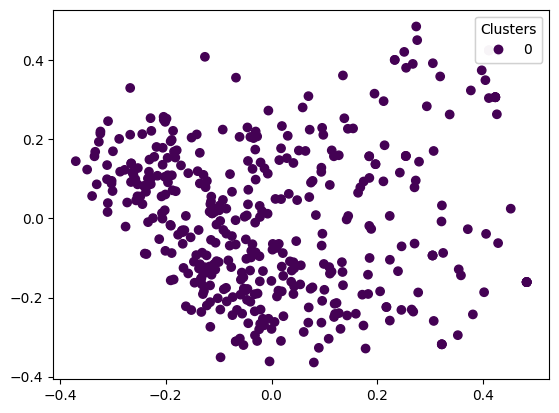

In [143]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = matched_list
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Set up Faiss for nearest neighbor search
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])
index.add(corpus_embeddings)

# Perform nearest neighbor search to get indices of similar embeddings
_, indices = index.search(corpus_embeddings, k=5)  # Get the 5 most similar embeddings for each sentence

# Perform DBSCAN clustering on the similar embeddings
clustering_model = DBSCAN(eps=1.5, min_samples=2, metric='cosine')
cluster_assignment = clustering_model.fit_predict(corpus_embeddings[indices[:, 1]])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
corpus_embeddings_2d = pca.fit_transform(corpus_embeddings)

# Plot the clustered embeddings
fig, ax = plt.subplots()
scatter = ax.scatter(corpus_embeddings_2d[:, 0], corpus_embeddings_2d[:, 1], c=cluster_assignment)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
ax.add_artist(legend1)
plt.show()


In [ ]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import dbscan
import torch
import numpy as np

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = matched_list[1:]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = [matched_list[0]]

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(corpus[idx], "(Score: {:.4f})".format(score))

    """
    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    """

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = matched_list[1:]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = [matched_list[0]]

for queries in matched_list:
  # Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
  top_k = min(100, len(corpus))
  for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    for score, idx in zip(top_results[0], top_results[1]):
        if(score > 0,6):
          matched_list.pop(idx)
      


In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util

#On charge le modèle de transformation de phrases "all-MiniLM-L6-v2" à partir de la bibliothèque SentenceTransformer.

model = SentenceTransformer('all-MiniLM-L6-v2')

#le nombre de voisins les plus proches à récupérer.
# Define the number of nearest neighbors to retrieve
k = 5

# Define the corpus of sentences
corpus = matched_list[1:]

# Encoder le corpus de phrases en utilisant le modèle de transformation de phrases.
corpus_embeddings = model.encode(corpus)

# Embed the query sentence
query = matched_list[0]
query_embedding = model.encode([query])

# Create an index for the corpus embeddings
#On crée un index FAISS pour les embeddings des phrases dans le corpus,
#en utilisant l'algorithme "IndexFlatIP" pour calculer le produit scalaire entre les embeddings.
d = len(corpus_embeddings[0])
index = faiss.IndexFlatIP(d)
index.add(np.array(corpus_embeddings))

# Search for the k nearest neighbors
D, I = index.search(np.array(query_embedding), k)

# Print the results
print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:")
for i, idx in enumerate(I[0]):
    print(corpus[idx], "(Score: {:.4f})".format(D[0][i]))

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN

#On charge le modèle de transformation de phrases "all-MiniLM-L6-v2" à partir de la bibliothèque SentenceTransformer.

model = SentenceTransformer('all-MiniLM-L6-v2')

#le nombre de voisins les plus proches à récupérer.
# Define the number of nearest neighbors to retrieve
k = 5

# Define the corpus of sentences
corpus = matched_list[1:]

# Encoder le corpus de phrases en utilisant le modèle de transformation de phrases.
corpus_embeddings = model.encode(corpus)

# Embed the query sentence
query = matched_list[0]
query_embedding = model.encode([query])

# Create an index for the corpus embeddings
#On crée un index FAISS pour les embeddings des phrases dans le corpus,
#en utilisant l'algorithme "IndexFlatIP" pour calculer le produit scalaire entre les embeddings.
d = len(corpus_embeddings[0])
index = faiss.IndexFlatIP(d)
index.add(np.array(corpus_embeddings))

# Search for the k nearest neighbors
D, I = index.search(np.array(query_embedding), k)

# Get the features to be clustered
features = np.array(matched_list)

# Define the parameters for the DBSCAN clustering algorithm
eps = 0.5
min_samples = 5

# Instantiate a DBSCAN object with the defined parameters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the DBSCAN object to the features
dbscan.fit(features)

# Get the labels for each point in the features
labels = dbscan.labels_

# Get the unique labels (i.e., cluster IDs) in the labels array
unique_labels = np.unique(labels)

# Loop through each label to print the corresponding features
for label in unique_labels:
    if label == -1:
        # This is noise, i.e., a feature that doesn't belong to any cluster
        print("Noise:")
    else:
        # This is a cluster
        print("Cluster", label, ":")
    # Print the features in the current cluster
    for idx, feature in enumerate(features[labels == label]):
        print("\t", idx+1, ":", feature)

In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util

#On charge le modèle de transformation de phrases "all-MiniLM-L6-v2" à partir de la bibliothèque SentenceTransformer.

model = SentenceTransformer('all-MiniLM-L6-v2')

#le nombre de voisins les plus proches à récupérer.
# Define the number of nearest neighbors to retrieve
k = 5

# Define the corpus of sentences
corpus = matched_list[1:]

# Encoder le corpus de phrases en utilisant le modèle de transformation de phrases.
corpus_embeddings = model.encode(corpus)

# Embed the query sentence
query = matched_list[0]
query_embedding = model.encode([query])

# Create an index for the corpus embeddings
#On crée un index FAISS pour les embeddings des phrases dans le corpus,
#en utilisant l'algorithme "IndexFlatIP" pour calculer le produit scalaire entre les embeddings.
d = len(corpus_embeddings[0])
index = faiss.IndexFlatIP(d)
index.add(np.array(corpus_embeddings))

print(index)

# Search for the k nearest neighbors
D, I = index.search(np.array(query_embedding), k)

# Print the results
print("\n\n======================\n\n")
print("Query:", query)
print("\nTop 5 most similar sentences in corpus:")
for i, idx in enumerate(I[0]):
    print(corpus[idx], "(Score: {:.4f})".format(D[0][i]))